In [25]:
import os

#현재 폴더 경로; 작업 폴더 기준
print(os.getcwd())

#현재 파일의 폴더 경로; 작업 파일 기준
print(os.path.dirname(os.path.realpath('__file__')))

C:\Users\revol
C:\Users\revol


In [26]:
%cd Chapter06

C:\Users\revol\Chapter06


In [1]:
import numpy as np
"""
신경망 학습의 목적 : 손실 함수의 값을 최대한 낮추는 매개변수를 찾는 것 - 최적화optimization
최적의 매개변수 값을 찾는 단서로 매개변수의 기울기(미분)을 이용함 - 확률적 경사 하강법(SGD)
SGD의 단점과 다른 최적화 기법을 소개
"""

# 6.1.1 모험가 이야기
# 6.1.2 확률적 경사 하강법(SGD)
"""
W ← W - η * ∂L/∂W
W : 갱신할 가중치 매개변수
∂L/∂W : W에 대한 손실 함수의 기울기
η : 학습률(정해진 상수값. 0.01, 0.001 등)
"""


# 최적화를 담당하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋다.
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


# 6.1.3 SGD의 단점
"""
SGD는 단순하고구현이 쉽지만, 문제에 따라 비효율적일 때가 있다.
다음 함수의 최솟값을 구해보자
f(x, y) = 1/20 * x² + y²
각 점에서 함수의 기울기는 (x/10, 2y)로 y축 방향은 가파른데 x축 방향은 완만하다.
또 최솟값은 (0, 0)이지만 기울기 대부분은 그 방향을 가리키지 않는다.
따라서 SGD를 적용하면 y축으로 지그재그로 수렴한다.
SGD는 비등방성anisotropy 함수(방향에 따라 성질, 여기서는 기울기가 달라지는 함수)에서는
탐색 경로가 비효율적이다.
이러한 단점을 개선해주는 모멘텀, AdaGrad, Adam이라는 방법을 소개한다.
"""

# 6.1.4 모멘텀
"""
모멘텀Momentum : 물리에서의 운동량
v ← αv - η * ∂L/∂W
W ← W + v
W : 갱신할 가중치 매개변수
∂L/∂W : W에 대한 손실 함수의 기울기
η : 학습률
v : 속도. 기울기 방향으로 힘을 받아 물체가 가속되는 것을 나타냄
α : 마찰/저항에 해당(0.9)
마치 공이 바닥을 구르는 듯한 움직임을 보여준다.
"""


class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


# 6.1.5 AdaGrad
"""
학습률이 너무 작으면 학습 시간이 길어지고 너무 크면 발산한다.다
학습률을 정하는 효과적인 기술로 학습률 감소learning rate decay가 있다.
학습을 진행하면서 학습률을 점차 줄여나간다.
AdaGrad 방식은 각각의 매개변수에 맞춰 적응적으로 학습률을 조정하며 학습을 진행한다.
h ← h + ∂L/∂W ⊙ ∂L/∂W
W ← W - η *1/√h * ∂L/∂W
⊙ : 행렬의 원소별 곱셈
h는 기존 기울기를 제곱해서 누적하며, 매개변수 갱신에 1/√h를 곱해준다.
매개변수가 크게 갠신된 원소는 학습률이 낮아진다.
NOTE : AdaGrad는 과거의 기울기를 제곱하여 계속 더하기 때문에 학습을 진행할 수록
갱신 강도가 약해진다. 이 문제를 개선한 기법으로 RMSProp이 있다.
RMSProp에서는 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영한다.
이를 지수이동평균Exponential Moving Average이라 하며 과거 기울기의 반영 규모를
기하급수적으로 감소시킨다.
"""


class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}

            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            # 1e-7 : h[key]에 0이 있는 경우 0으로 나누는 것을 방지. 이 값도 설정 가능


# 6.1.6 Adam
"""
모멘텀과 AdaGrad의 두 기법을 융합한 기법. 2015년에 제안되었음.
또 하이퍼파라미터의 '편향 보정'이 진행됨
RMSprop과 Adam은 common/optizizer.py에서 구현해둠
"""

# 6.1.7 어느 갱신 방법을 이용할 것인가?
"""
각 방법의 그래프는 optimizer_compare_naive.py를 참고
모든 문제에서 항상 뛰어난 기법은 없다. 하이퍼파라미터를 어떻게 설정하느냐에 따라서도
결과가 달라진다.
"""

# 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교
"""
숫자 인식을 대상으로 네 기법을 비교한 그래프는 optimizer_compare_mnist.py 참고
각 층이 100개의 뉴런으로 구성된 5층 신경망에서 ReLU를 활성화 함수로 사용
인식률은 AdaGrad > Adam > Momentum >> SGD 순서였음
"""

'\n숫자 인식을 대상으로 네 기법을 비교한 그래프는 optimizer_compare_mnist.py 참고\n각 층이 100개의 뉴런으로 구성된 5층 신경망에서 ReLU를 활성화 함수로 사용\n인식률은 AdaGrad > Adam > Momentum >> SGD 순서였음\n'

In [11]:
!pip install import_ipynb

In [30]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath('__file__'))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_ont_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_ont_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_ont_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


===========iteration:0===========
SGD:2.358149603148091
Momentum:2.4877977810857246
AdaGrad:2.1239070578319215
Adam:2.1627192859921838
===========iteration:100===========
SGD:1.7587978948292506
Momentum:0.35943320725474437
AdaGrad:0.12809708256568494
Adam:0.24009211599276395
===========iteration:200===========
SGD:0.9244655601373308
Momentum:0.28389018884299677
AdaGrad:0.06404900621052981
Adam:0.16866783691033296
===========iteration:300===========
SGD:0.5605016897879872
Momentum:0.2832146205186409
AdaGrad:0.0934589927086255
Adam:0.20879736799049162
===========iteration:400===========
SGD:0.547176229601556
Momentum:0.3003557437766248
AdaGrad:0.07133870613542495
Adam:0.17098902468066787
===========iteration:500===========
SGD:0.29520191349080177
Momentum:0.135706863031061
AdaGrad:0.06364079346818184
Adam:0.07189923027053743
===========iteration:600===========
SGD:0.4507981428310581
Momentum:0.22635540161944145
AdaGrad:0.0607679086951324
Adam:0.14561091017752997
===========iteration:700=

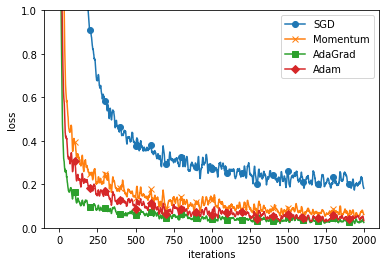

In [32]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)

from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
# optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key],
        markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()